In [21]:
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
from itertools import product
from datetime import *
from dateutil.relativedelta import *

Загрузим данные.

In [2]:
wage = pd.read_csv('WAG_C_M.csv', sep=';', index_col='month', parse_dates=True, dayfirst=True)
wage.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


Построим график нашего временного ряда.

Text(0.5,1,'Средняя зарплата в России')

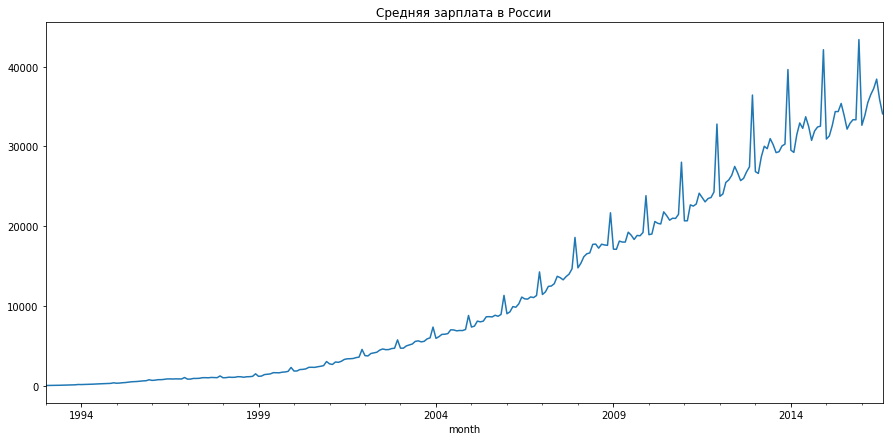

In [3]:
plt.figure(figsize=(15,7))
wage.WAG_C_M.plot()
plt.title('Средняя зарплата в России')

Сделаем декомпозицию ряда методом STL (https://www.wessa.net/download/stl.pdf).

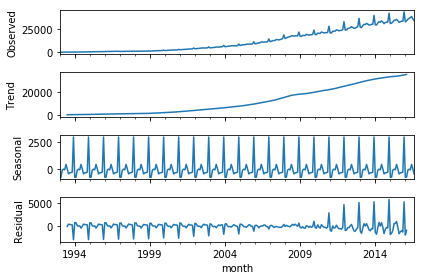

In [4]:
_ = sm.tsa.seasonal_decompose(wage.WAG_C_M).plot()

Применим метод Дики-Фуллера.

In [5]:
print('Метод Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(wage.WAG_C_M)[1])

Метод Дики-Фуллера: p=0.991850


Гипотеза нестационарности этого ряда не отвергается.

## Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


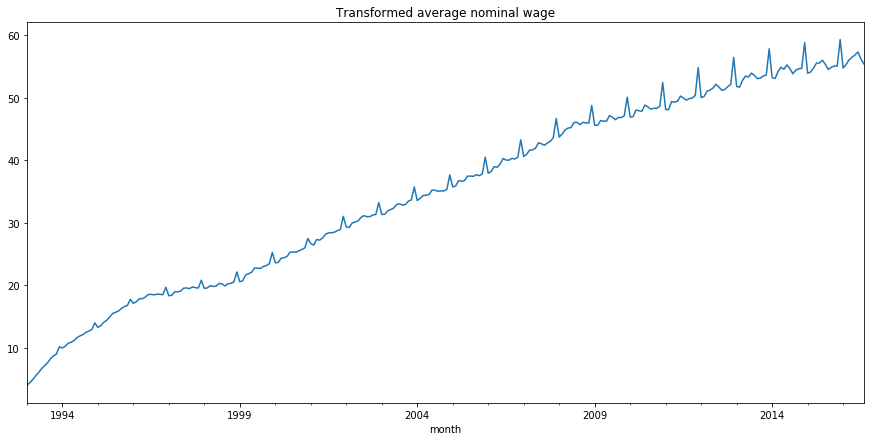

In [6]:
wage['WAG_C_M_box'], lmbda = stats.boxcox(wage.WAG_C_M)

plt.figure(figsize=(15,7))
wage.WAG_C_M_box.plot()
plt.title(u'Transformed average nominal wage')

print('Оптимальный параметр преобразования Бокса-Кокса: %f' % lmbda)
print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(wage.WAG_C_M_box)[1])

## Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


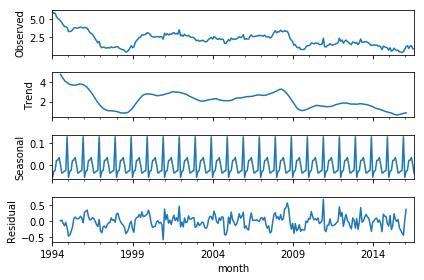

In [7]:
wage['WAG_C_M_box_diff'] = wage.WAG_C_M_box - wage.WAG_C_M_box.shift(12)
_ = sm.tsa.seasonal_decompose(wage.WAG_C_M_box_diff.dropna()).plot()
print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(wage.WAG_C_M_box_diff.dropna())[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, НО полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


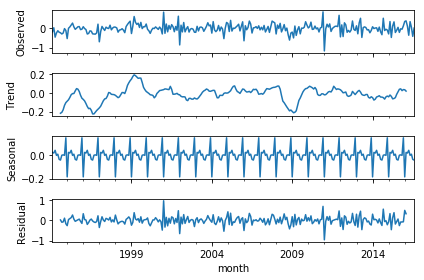

In [8]:
wage['WAG_C_M_box_diff2'] = wage.WAG_C_M_box_diff - wage.WAG_C_M_box_diff.shift(1)
_ = sm.tsa.seasonal_decompose(wage.WAG_C_M_box_diff2.dropna()).plot()
print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(wage.WAG_C_M_box_diff2.dropna())[1])

Гипотеза нестационарности отвергается.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

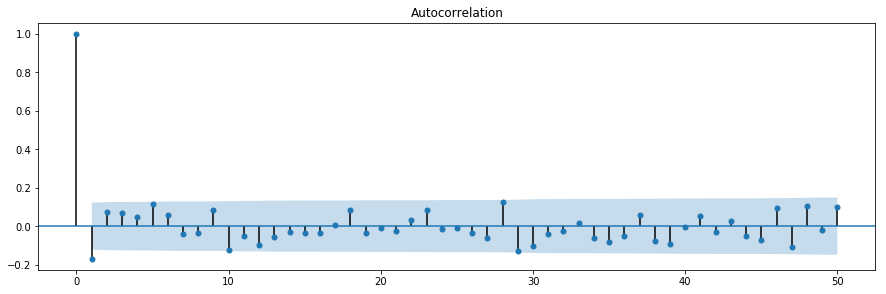

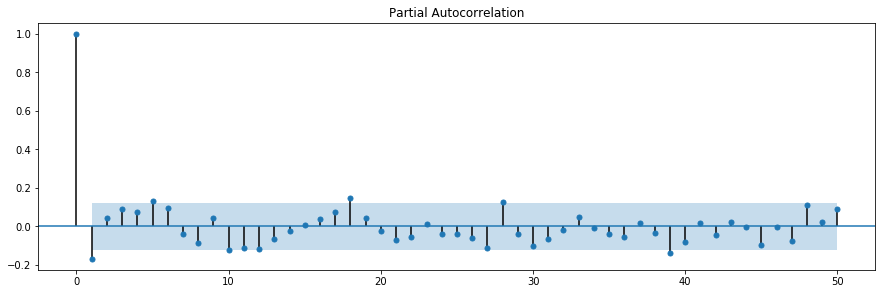

In [9]:
plt.figure(figsize=(15,10))

ax = plt.subplot(211)
_ = sm.graphics.tsa.plot_acf(wage.WAG_C_M_box_diff2.dropna()[12:].squeeze(), lags=50, ax=ax)
plt.show()

plt.figure(figsize=(15,10))
ax = plt.subplot(212)
_ = sm.graphics.tsa.plot_pacf(wage.WAG_C_M_box_diff2.dropna()[12:].squeeze(), lags=50, ax=ax)
plt.show()

Начальные приближения: Q = 0, q = 1, P = 1, p = 18

In [10]:
ps = range(0, 19)
d = 1
qs = range(0, 2)
Ps = range(0, 2)
D = 1
Qs = range(0, 1)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

76

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
Wall time: 1min 50s


In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
46  (12, 0, 1, 0) -10.262124
42  (11, 0, 1, 0)  -9.662085
44  (11, 1, 1, 0)  -9.509328
69  (18, 0, 0, 0)  -8.464590
50  (13, 0, 1, 0)  -8.290497


Лучшая модель:

In [14]:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                         WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(12, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  19.131
Date:                             Fri, 03 Aug 2018   AIC                            -10.262
Time:                                     14:23:39   BIC                             40.824
Sample:                                 01-01-1993   HQIC                            10.219
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2281      0.047     -4.840      0.000      -0.320      -0.136
ar.L2          0.0086      

Посмотрим на остатки модели:

Критерий Стьюдента: p=0.182332
Критерий Дики-Фуллера: p=0.000000


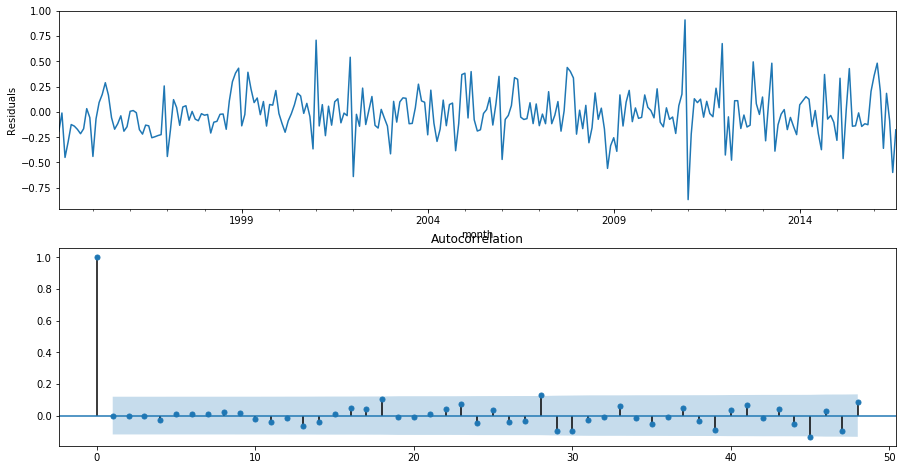

In [15]:
plt.figure(figsize = (15,8))

plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
_ = sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

In [16]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

Text(0.5,0,'Время')

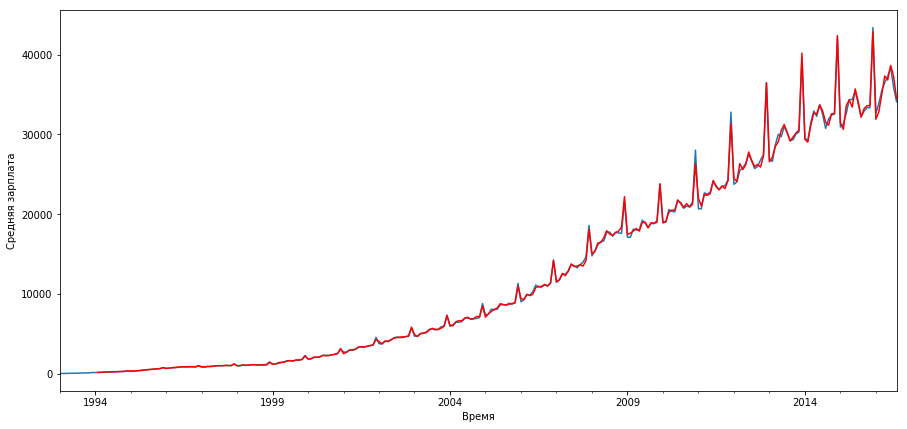

In [19]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize=(15,7))
wage.WAG_C_M.plot()
wage.model[13:].plot(color='r')
plt.ylabel('Средняя зарплата')
plt.xlabel('Время')

## Прогноз

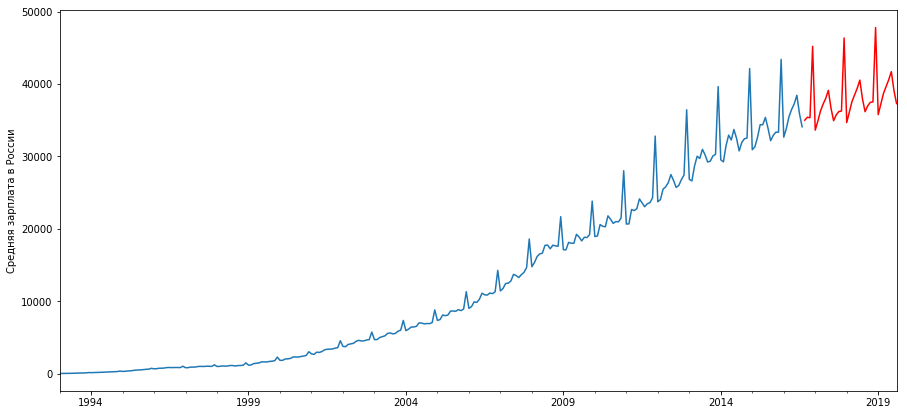

In [22]:
wage2 = wage[['WAG_C_M']]

date_list = [datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=wage2.columns)

wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=284, end=325), lmbda)

plt.figure(figsize=(15,7))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Средняя зарплата в России')
plt.show()